In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
import cv2
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
import networkx as nx

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.data import InterventionSamplerBase
from omnilearn import viz as viz_util

from sklearn.decomposition import PCA
import sklearn.datasets

from src import sample_full_interventions, response_mat, factor_reponses
from src.responses import sample_full_interventions

# import gpumap
from c3linearize import linearize, class_graph


In [2]:
device = 'cuda'
figure_root = Path('figures/responses')
figure_root = None
if figure_root is not None and not figure_root.exists():
    figure_root.mkdir()
seed = 10
B = 128
N = 16
G = 32

In [3]:
dataset = fig.quick_run('load-data', name='3dshapes', mode='full', labeled=True, shuffle=False, seed=seed)
# dataset = fig.quick_run('load-data', name='full-mpi3d', labeled=True, shuffle=False, sort=True, seed=seed)
# images = dataset.images
# labels = dataset.labels
# images.shape, labels.shape
len(dataset)

| dataset: None (by default)
| CREATING . (type=dataset)
|  > num_workers: 0 (by default)
|  > batch_size: 64 (by default)
|  > shuffle: False
|  > drop_last: False (by default)
|  > step_device --> device: 'cuda' (by default)
|  > infinite: False (by default)
|  > extractor: None (by default)
|  > allow_batched: True (by default)
|  > split: {} (by default)
|  > shuffle-split: True (by default)
|  > split-src: 'train' (by default)
|  > _dataset_type --> dataset-name --> name: '3dshapes'
|  > _dataset_mod: [] (by default)
|  > default_mode --> mode: 'full'
|  > mode-aliases: {} (by default)
|  > seed: 10
|  > device: 'cuda' (by default)
|  > pin_memory: False (by default)
|  > epoch_seed --> seed: 10
|  > skip_load: False (by default)
|  > CREATING . (type=dataset/3dshapes)
|  >  > mode: 'full'
|  >  > labeled: True
|  >  > label_type: 'class' (by default)
|  >  > din: (3, 64, 64) (by default)
|  >  > dout: 6 (by default)
|  >  > device: 'cuda' (by default)
|  >  > fid_ident: None (by 

480000

In [4]:
batch = dataset.get_batch(shuffle=True)
X, Y = batch
X.shape, Y.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64, 6]))

In [5]:
factors = dataset.get_factor_order()
factor_sizes = dataset.get_factor_sizes()
factors, factor_sizes

(['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation'],
 [10, 10, 10, 8, 4, 15])

In [6]:
sampler = InterventionSamplerBase(dataset)
interventions = sample_full_interventions(sampler, num_groups=20, pbar=tqdm)

  0%|          | 0/6 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


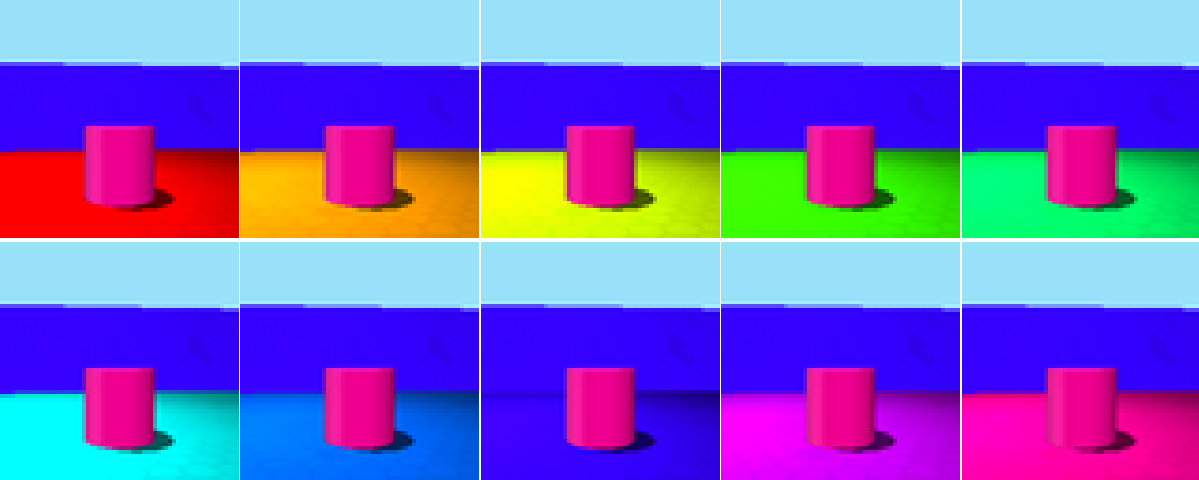

In [7]:
intervention_dim = 0
intervention_imgs = sampler.full_intervention(intervention_dim)
imgs = intervention_imgs
util.plot_imgs(imgs);

In [8]:
root = Path(r'C:\Users\anwan\Documents\workspace\sae\trained_nets')
# root = Path(r'C:\Users\anwan\Documents\workspace\trained_nets')
# root = Path(r'C:/Users/anwan/Documents/workspace/exts/')
run_names = os.listdir(str(root))
len(run_names)

238

In [9]:
print(tabulate(enumerate(run_names)))

---  -------------------------------------------------
  0  3ds_ae0_e-c12_d-c12_210125-045343
  1  3ds_ae0_e-c12_d-c12_coord_210125-045521
  2  3ds_ae0_e-c12_d-c12_mish_210125-050038
  3  3ds_ae0_e-c12_d-c12_res-nn_210125-045937
  4  3ds_ae0_e-c12_d-c12_res_210125-045520
  5  3ds_ae0_e-c12_d-s12_210125-045438
  6  3ds_ae0_e-c12_d-s12_coord_210125-050236
  7  3ds_ae0_e-c12_d-s12_mish_210125-050335
  8  3ds_ae0_e-c12_d-s12_nosplit_210125-045438
  9  3ds_ae0_e-c12_d-s12_res-nn_210125-050336
 10  3ds_ae0_e-c12_d-s12_res_210125-050235
 11  3ds_ae0_e-c12_d-s2_210125-132645
 12  3ds_ae0_e-c12_d-s2_nosplit_210125-134343
 13  3ds_ae0_e-c12_d-s3_210125-134123
 14  3ds_ae0_e-c12_d-s3_nosplit_210125-134835
 15  3ds_ae0_e-c12_d-s4_210125-045438
 16  3ds_ae0_e-c12_d-s4_mish_210125-140253
 17  3ds_ae0_e-c12_d-s4_nosplit_210125-045440
 18  3ds_ae0_e-c12_d-s4_seed2_210125-133117
 19  3ds_ae0_e-c12_d-s6_210125-045438
 20  3ds_ae0_e-c12_d-s6_lrp0003_210125-171518
 21  3ds_ae0_e-c12_d-s6_lrp0004_210125-17

In [108]:
# run_name = run_names[7] # s12 mish
# run_name = run_names[5] # s12
# run_name = random.choice(run_names)
# run_name = run_names[0] # ae conv
# run_name = run_names[49]
run_name = run_names[57]
# run_name = run_names[56]

# run_name = run_names[32]

# run_name = '3ds_vae2_e-c12_d-c12_210125-045344'
# run_name = '3ds_vae1_e-l12_d-l12_210125-045439'
# run_name = '3ds_vae16_e-c12_d-c12_210125-045345'

# run_name = short[0]

# run_name = '3ds_vae4_d-conv_b4-d24_210411-165936'
run_name = '3ds_ae_e-c12_d-s12_tanh-seed10_210414-171333'
# run_name = '3ds_ae_e-c12_d-s12_seed3-mish_210126-004805'
# run_name = '3ds_ae_e-c12_d-s12_d24-lr0001_210414-171331'
run_name

'3ds_ae_e-c12_d-s12_tanh-seed10_210414-171333'

In [109]:
load_config = fig.get_config(path=run_name, root=str(root), **{'override.device':device})
load_config.set_silent(True)
run = fig.run('load-run', load_config)
A = run.get_config()
A.set_silent(True)
info = A.pull('info')
info

{'arch_type': 'strc',
 'dataset_type': '3ds',
 'dec_type': 's12',
 'enc_type': 'c12',
 'extra': 'tanh-seed10',
 'model_type': 'ae',
 'size': 64}

In [110]:
if figure_root is not None:
    figure_dir = figure_root / run_name
    if not figure_dir.exists():
        figure_dir.mkdir()
else:
    figure_dir = None
model = run.get_model()
model.switch_to('val')
model.to(device);

Hybrid_Autoencoder(
  (encoder): MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): Tanh()
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): Tanh()
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): Tanh()
      )
      (3): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=(2, 2), strid

In [111]:
# ckptname = '1280'
# info = None
# if figure_root is not None:
#     figure_dir = figure_root / f'tf_model_{ckptname}'
#     if not figure_dir.exists():
#         figure_dir.mkdir()
# else:
#     figure_dir = None
# model = fig.quick_run('load-model', 'a/dislib', 'm/vae', device=device, **{'tf-ckpt-path': ckptname, 'model.nonlin': 'relu'})
# model

In [112]:
figure_dir

In [113]:
# dataset = run.get_dataset()
# dataset.switch_to('val')
# len(dataset)

In [114]:
# if R is None:
#     with torch.no_grad():
#         R, Q = model(X, ret_q=True)
#         if isinstance(Q, distrib.Distribution):
#             Q = Q.loc

In [115]:
# util.plot_imgs(X[:N])
# plt.suptitle('Original')
# plt.subplots_adjust(top=0.95)
# util.plot_imgs(R[:N])
# plt.suptitle('Reconstructions')
# plt.subplots_adjust(top=0.95)
# pass

In [116]:
fullQ = []
total = 10000
bs = 100
loader = dataset.get_loader(infinite=True, shuffle=True, seed=0, batch_size=bs)
loader = iter(loader)
pbar = tqdm(total=total)
while len(fullQ) < total//bs:
    batch = next(loader)
    x = model._process_batch(batch).original
    with torch.no_grad():
        q = model.encode(x)
        if isinstance(q, distrib.Distribution):
            q = q.loc
        fullQ.append(q)
    pbar.update(bs)
del loader
fullQ = torch.cat(fullQ)
D = fullQ.size(-1)
fullQ.shape

  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 12])

In [117]:
scales = fullQ.std(0)
# scales = None

<IPython.core.display.Javascript object>


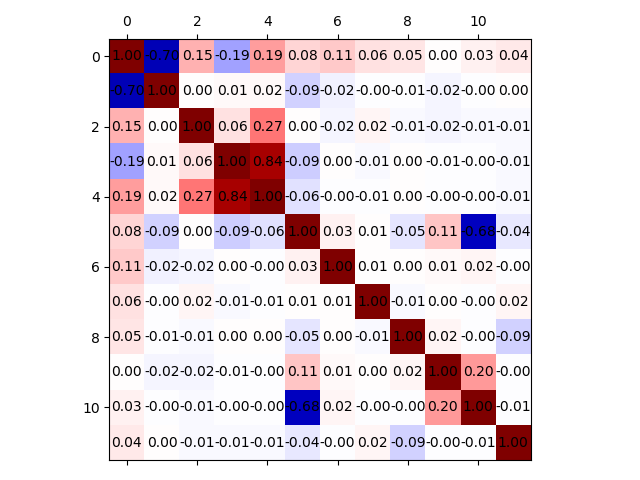

In [118]:
C = np.cov(fullQ.div(scales).cpu().t().numpy())
util.plot_mat(C, val_fmt=2, cmap='seismic', vmin=-1, vmax=1)
plt.tight_layout()
# util.save_figure(f'{run_name}_cov', root=figure_dir)
util.save_figure(f'cov', root=figure_dir)

In [119]:
R = response_mat(fullQ[:100], model.encode, model.decode, scales=scales, dist_type='rms', force_different=True)

In [216]:
# util.plot_mat(R, val_fmt=1) # responses
# plt.ylabel('Intervention')
# plt.xlabel('Response')
# plt.tight_layout()
# # util.save_figure(f'{run_name}_full_responses', root=figure_dir)
# util.save_figure(f'full_responses', root=figure_dir)

In [ ]:
threshold = 0.4

In [ ]:
sel = torch.arange(len(R))[R.diag() > threshold]
bsel = torch.arange(len(R))[R.diag() <= threshold]
sel, bsel

In [121]:
# # epsilon interventions
# mags = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
# frames = []
# for mag in tqdm(mags):
#     Rm = response_mat(fullQ[:100], model.encode, model.decode, scales=scales, mag=mag, dist_type='rms', force_different=True)
#     fg, _ = util.plot_mat(Rm, val_fmt=1) # responses
#     plt.ylabel('Intervention')
#     plt.xlabel('Response')
#     plt.tight_layout()
#     frame = util.fig_to_rgba(fg)
#     plt.close(fg)
#     frames.append(frame)
# frames = np.stack(frames)
# frames.shape

In [122]:
# mov = util.Video(frames)
# if figure_dir is not None:
#     path = figure_dir / f'seq{bidx}.mp4'
# #     path = figure_dir / f'{run.name}_seq{bidx}.mp4'
#     mov.export(path)
#     print(f'Movie saved: {str(path)}')
# mov.play('jupyter', scale=1, fps=5)

<IPython.core.display.Javascript object>


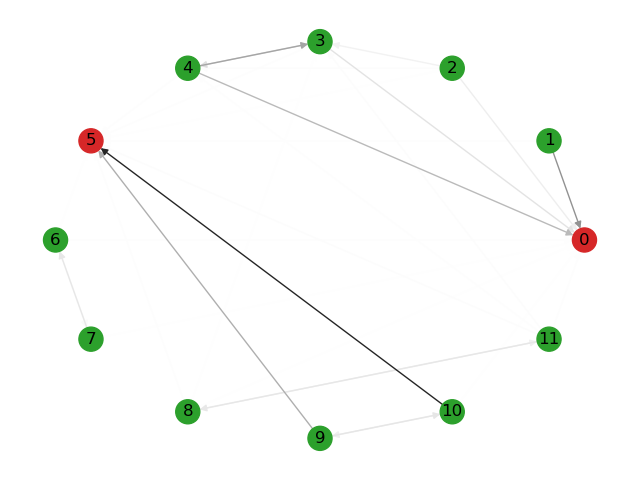

In [124]:
# G = nx.from_numpy_matrix(R.cpu().pow(2).numpy(), create_using=nx.MultiDiGraph)

# colors = 'C1'
# colors = ['C2' if i in sel else 'C3' for i in range(len(G))]

# edges,weights = zip(*sorted(nx.get_edge_attributes(G,'weight').items(), key=lambda x: x[-1], reverse=False))

# try:
#     pos = nx.planar_layout(G)
# except:
# #     pos = nx.spring_layout(G)
#     pos = nx.circular_layout(G)

# kwargs = dict(pos=pos, node_color=colors, with_labels=True,
#               edgelist=edges, edge_color=weights,
#               edge_cmap=plt.get_cmap('binary'), vmin=0)
# plt.figure()
# nx.draw(G, **kwargs)
# # util.save_figure(f'{run_name}_graph', root=figure_dir)
# util.save_figure(f'graph', root=figure_dir)

<IPython.core.display.Javascript object>


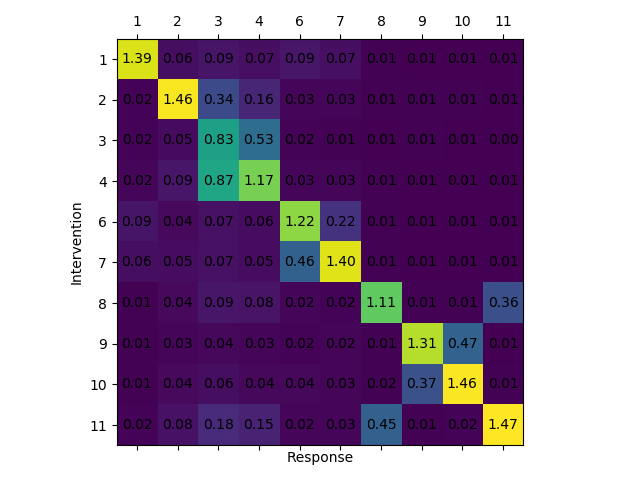

In [125]:
util.plot_mat(R[sel][:,sel], val_fmt=2) # responses
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.xticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.yticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.tight_layout()
# util.save_figure(f'{run_name}_sel_responses', root=figure_dir)
util.save_figure(f'sel_responses', root=figure_dir)

In [215]:
# G = nx.from_numpy_matrix(R[sel][:,sel].cpu().pow(2).numpy(), create_using=nx.MultiDiGraph)

# colors = 'C2'
# # colors = ['C2' if i in sel else 'C3' for i in range(len(G))]

# edges,weights = zip(*sorted(nx.get_edge_attributes(G,'weight').items(), key=lambda x: x[-1], reverse=False))

# try:
#     pos = nx.planar_layout(G)
# except:
# #     pos = nx.spring_layout(G)
#     pos = nx.circular_layout(G)

# kwargs = dict(pos=pos, node_color=colors, labels={i:str(n.item()) for i,n in enumerate(sel)},#, with_labels=True,
#               edgelist=edges, edge_color=weights,
#               edge_cmap=plt.get_cmap('binary'), vmin=0)
# plt.figure()
# nx.draw(G, **kwargs)
# # util.save_figure(f'{run_name}_graph', root=figure_dir)
# util.save_figure(f'sel-graph', root=figure_dir)

In [240]:
resp = R#[sel][:,sel]
resp.shape

torch.Size([12, 12])

In [241]:
pairs = {}
imps = []
for i,j in zip(*torch.triu_indices(*resp.shape, 1).tolist()):
    if resp[i,i] > threshold and resp[j,j] > threshold:
        imps.append(resp[i,j].item() + resp[j,i].item())
        pairs[i,j] = imps[-1]
imps = torch.tensor(imps).float()
pairs = {k:v for k,v in pairs.items() if v >= threshold}
pairs, vitals = zip(*sorted(pairs.items(), key=lambda x:x[1], reverse=True))
pairs, vitals

(((3, 4), (9, 10), (8, 11), (6, 7)),
 (1.4004542231559753,
  0.836885541677475,
  0.8151750266551971,
  0.680492490530014))

<IPython.core.display.Javascript object>


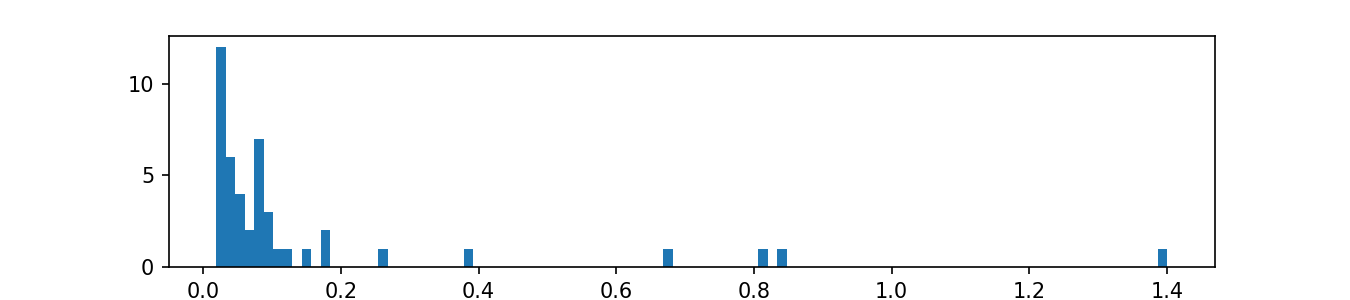

In [242]:
plt.figure(figsize=(9,2))
plt.hist(imps, bins=100);

In [245]:
ind = pairs[0]
ind

(3, 4)

In [335]:
Q = fullQ[:100].detach().cpu()
Q.shape

torch.Size([100, 12])

In [351]:
pts = Q[:,ind]
mu = pts.mean(0)
pts = pts.sub(mu.unsqueeze(0))
pts.shape

torch.Size([100, 2])

<IPython.core.display.Javascript object>


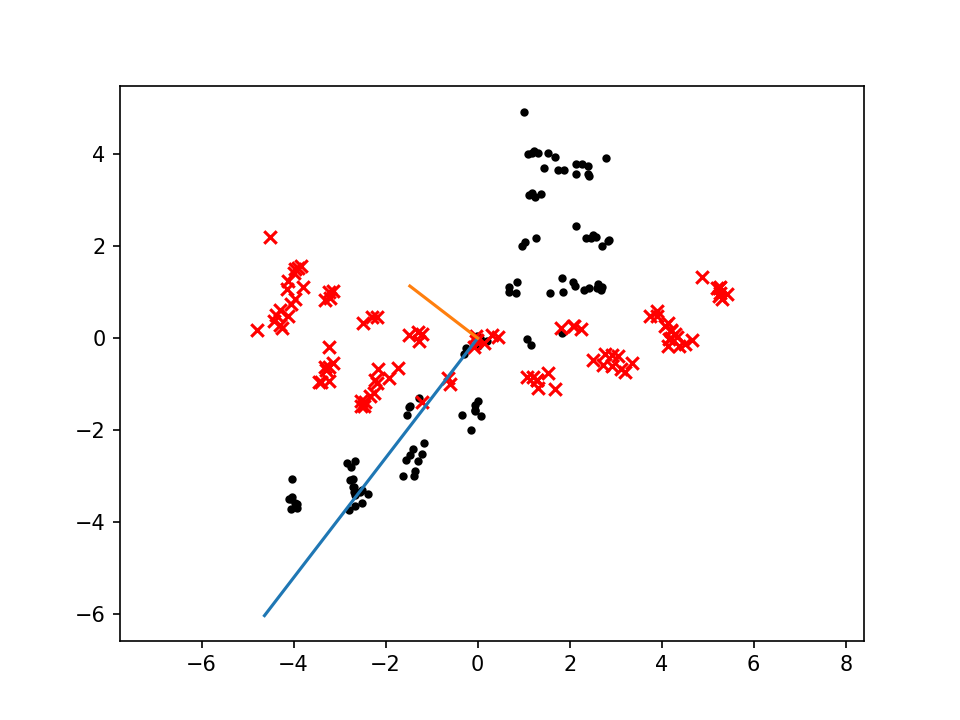

In [352]:
plt.figure()
plt.scatter(*pts.t(), marker='.', c='k');

In [353]:
U, S, V = torch.svd(pts.t() @ pts / (B - 1))
S = S.sqrt()
S

tensor([7.6053, 1.8588])

In [354]:
ars = torch.stack([torch.zeros(2), S[0]*U[0]])
plt.plot(*ars.t());
ars = torch.stack([torch.zeros(2), S[1]*U[1]])
plt.plot(*ars.t());
plt.axis('equal');

In [355]:
# se2 = torch.cat([U, mu.unsqueeze(-1)],1)
# se2 = torch.cat([se2, torch.tensor([[0,0,1]]).float()])
# se2[:-1,-1] = 0.
se2 = U.clone()
se2

tensor([[-0.6093, -0.7929],
        [-0.7929,  0.6093]])

In [356]:
fixed = pts @ se2
fixed.shape

torch.Size([100, 2])

In [357]:
plt.scatter(*fixed.t(), marker='x', c='r');

In [127]:
mats, lts = factor_reponses(model.encode, model.decode, interventions, pbar=tqdm, include_q=True, 
                       resp_kwargs=dict(scales=scales,force_different=True))
# W = mats.mean(-1).mean(1)

M_old = mats.min(1)[0].max(-1)[0]
M = mats.min(1)[0].diagonal(0,-1,-2)
# M = mats.mean(1).max(-1)[0]

mats.shape, len(lts), M.shape

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

(torch.Size([6, 20, 12, 12]), 6, torch.Size([6, 12]))

<IPython.core.display.Javascript object>


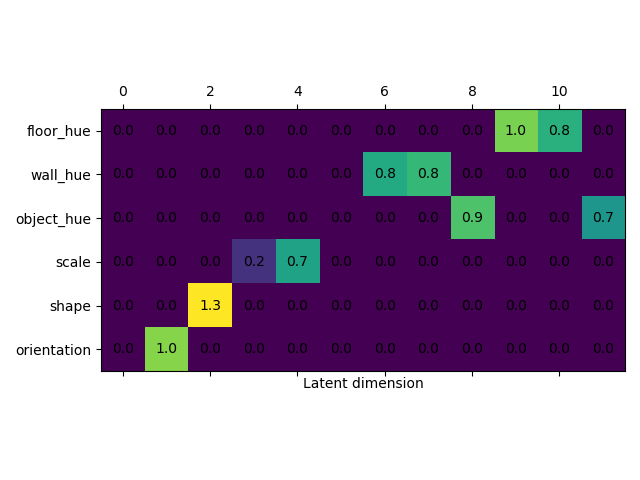

In [128]:
util.plot_mat(M, val_fmt=1)
plt.yticks(range(len(factors)), factors)
plt.xlabel('Latent dimension')
plt.tight_layout()
# util.save_figure(f'{run_name}_factor-responses', root=figure_dir)
util.save_figure(f'factor-responses', root=figure_dir)
pass # an intervention on which latent dimension responds the most given that the intervention can 
#      only change the given factor of variation

In [129]:
# util.plot_mat(M_old, val_fmt=2)
# plt.yticks(range(len(factors)), factors)
# plt.xlabel('Latent dimension')
# plt.tight_layout()
# # util.save_figure(f'{run_name}_factor-responses', root=figure_dir)
# util.save_figure(f'old-factor-responses', root=figure_dir)
# pass # an intervention on which latent dimension responds the most given that the intervention can 
# #      only change the given factor of variation

In [130]:
# full = interventions[3][1]
# with torch.no_grad():
#     fq = model.encode(full.to(device))
#     if isinstance(fq, distrib.Normal):
#         fq = fq.mean

In [131]:
# with torch.no_grad():
#     hq = model.hybridize(fq)
#     vim = model.decode(hq.to(device))
# util.plot_imgs(full);
# util.plot_imgs(vim);

In [132]:
bidx = 0

In [133]:
with torch.no_grad():
    Q = model.encode(X.to(device))
    if isinstance(Q, distrib.Normal):
        Q = Q.mean
q = Q[bidx]
Q.shape, q.shape

(torch.Size([64, 12]), torch.Size([12]))

In [134]:
n = 16
steps = 40
# info.steps = 20
# info.steps = 7
# info.steps = 5
ntrav = 1
stretch = 0.1

In [135]:
rg = Q.max(0)[0] - Q.min(0)[0]
rg = rg.unsqueeze(-1)
mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg

In [136]:
tH, tW = 4,3
if info is None:
    tH, tW = 5, 2
else:
    if info['dec_type'] == 's6':
        tH, tW = 6,2
    if info['dec_type'] == 's3':
        tH, tW = 3,4

vecs = viz_util.get_traversal_vecs(q.unsqueeze(0), steps=steps,
      mnmx=(mn,mx)).contiguous()
# deltas = torch.diagonal(vecs, dim1=-3, dim2=-1)
# vecs.shape
walks = viz_util.get_traversals(vecs, model.decode, device=device).cpu()
# diffs = viz_util.compute_diffs(walks)
walks.shape
    
if walks.size(1) != tH*tW:
    tH, tW = util.calc_tiling(walks.size(1))
    
tH, tW

(4, 3)

In [137]:
full = walks

# tH, tW = util.calc_tiling(full.size(1), prefer_tall=True)
B, N, S, C, H, W = full.shape


full = full.view(B, tH, tW, S, C, H, W)
# print(full.shape)
full = full.squeeze(0).permute(2,0,4,1,5,3).contiguous()
frames = full.view(S, tH*H, tW*W, C).mul(255).byte().numpy()



frames.shape
# full = full.permute(0,1,2,5,3,6,4).contiguous().view(B, run.tH, run.tW*H, S*W, C).squeeze(0)

(40, 256, 192, 3)

In [138]:

font                   = cv2.FONT_HERSHEY_SIMPLEX
font                   = cv2.FONT_HERSHEY_COMPLEX
fontScale              = 0.5
fontColor              = (0,0,0)
lineType               = 1

px, py = 2, 12

for frame in frames:
    for i,j in np.ndindex(tH, tW):
        idx = i*tW+j
        cv2.putText(frame, f'{idx}', 
            (px+H*j, py+W*i), 
            font, 
            fontScale,
            fontColor,
            lineType)


<IPython.core.display.Javascript object>


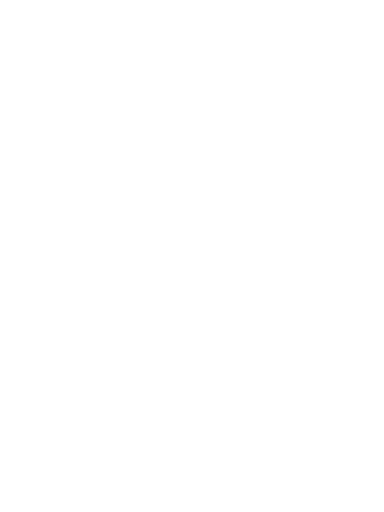

In [139]:
mov = util.Video(frames)
if figure_dir is not None:
    path = figure_dir / f'seq{bidx}.mp4'
#     path = figure_dir / f'{run.name}_seq{bidx}.mp4'
    mov.export(path)
    print(f'Movie saved: {str(path)}')
mov.play('jupyter', scale=2)

<IPython.core.display.Javascript object>


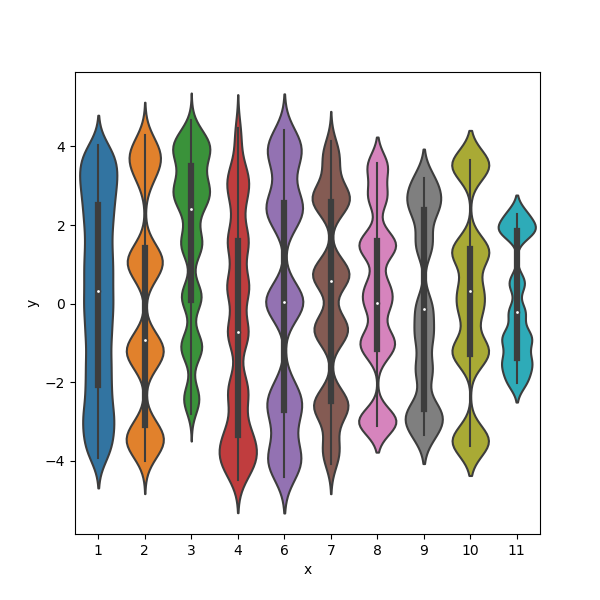

In [140]:
util.plot_distribs(fullQ.t()[sel].cpu());
plt.xticks(np.arange(len(sel)),sel.tolist());
util.save_figure(f'latent_marginals', root=figure_dir);

<IPython.core.display.Javascript object>


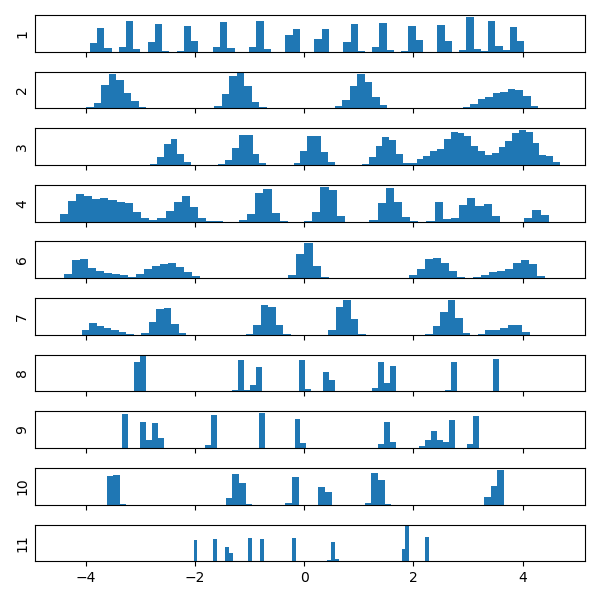

In [141]:
pts = fullQ.cpu().t()[sel]
fg, axs = util.plot_hists(pts, bins=60, sharex=True);
for ax, s in zip(axs, sel.tolist()):
    plt.sca(ax)
    plt.ylabel(str(s))
#     plt.xticks([])
    plt.yticks([])
plt.tight_layout()
util.save_figure(f'latent_hists', root=figure_dir);

In [142]:

factor_dim = 4

ix, iy = 3, 4
ix, iy = 4, 6
ix, iy = 0, 6

ix, iy = None, None
# ix, iy = 2, 7

In [143]:
bidx = 0
q = Q[bidx]

In [144]:
if ix is not None and iy is not None:
    n = 12
    h, w = n, n

    mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg
    mn, mx = mn.view(-1), mx.view(-1)

    cx, cy = torch.meshgrid(torch.linspace(mn[ix],mx[ix],h), torch.linspace(mn[iy],mx[iy],h))
    cx = cx.reshape(-1)
    cy = cy.reshape(-1)

    vecs = q.expand(len(cx), q.size(0)).contiguous()
    vecs[:, ix] = cx
    vecs[:, iy] = cy

    with torch.no_grad():
        x = model.decode(vecs)
    # x = x.view(h,w,*x.shape[1:])
        r,qr = model(x, ret_q=True)
        if isinstance(qr, distrib.Distribution):
            qr = qr.loc
    x = x.contiguous()
    r = r.contiguous()
    latent_losses = F.mse_loss(vecs,qr, reduction='none').view(x.shape[0],-1).mean(-1).view(h,w)
    img_losses = F.mse_loss(x,r, reduction='none').view(x.shape[0],-1).mean(-1).view(h,w)
    
    C, H, W = x.shape[-3:]
    x = x.cpu().numpy().reshape(h,w,C,H,W).transpose(1,0,2,3,4)[::-1].reshape(h*w,C,H,W)
    r = r.cpu().numpy().reshape(h,w,C,H,W).transpose(1,0,2,3,4)[::-1].reshape(h*w,C,H,W)
    #.reshape(h,w,*x.shape[1:]).permute(1,0,2,3,4).reshape(-1,*x.shape[1:]).cpu().numpy()
#     r = r.reshape(h,w,*x.shape[1:]).permute(1,0,2,3,4).reshape(-1,*x.shape[1:]).cpu().numpy()
    
    util.plot_imgs(x,H=h,W=w);
    util.save_figure(f'2D_traversal_{ix}_{iy}', root=figure_dir);
    
    util.plot_imgs(r,H=h,W=w);
    util.save_figure(f'2D_traversal_recovery_{ix}_{iy}', root=figure_dir);
    
    util.plot_mat(latent_losses.t().cpu().numpy()[::-1], val_fmt=1, figsize=(5,5));
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)
    util.save_figure(f'2D_traversal_latent_error_{ix}_{iy}', root=figure_dir);
    
    util.plot_mat(img_losses.t().cpu().numpy()[::-1], figsize=(5,5));
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)
    util.save_figure(f'2D_traversal_image_error_{ix}_{iy}', root=figure_dir);
    
    start, end = vecs.cpu().t()[[ix,iy]], qr.cpu().t()[[ix,iy]]

    plt.figure()
    plt.scatter(*start)
    delta = end - start
    # sel = slice(0,-1)
    plt.quiver(*start, *delta,angles='xy', scale_units='xy', scale=1, lw=0.5, alpha=0.5)
    plt.scatter(*end)
    plt.xlabel(f'Dimension {ix}')
    plt.ylabel(f'Dimension {iy}')
    
    inv_imgs = torch.stack([sampler.full_intervention(factor_dim) for _ in range(10)])
    B, N, C, H, W = inv_imgs.shape
    with torch.no_grad():
        int_q = model.encode(inv_imgs.to(device).view(B*N,C,H,W))
        if isinstance(int_q, distrib.Distribution):
            int_q = int_q.loc
        int_q = int_q.view(B, N, -1).cpu()
    plt.plot(*int_q[...,[ix,iy]].permute(2,1,0), c='r', ls='--', lw=0.5);
    plt.tight_layout()
    util.save_figure(f'2D_traversal_projection_factor{factor_dim}_{ix}_{iy}', root=figure_dir);

In [145]:
n = 20
h, w = n, n

bidx = 0
q = Q[bidx]

mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg
mn, mx = mn.view(-1), mx.view(-1)

ix, iy = 3, 4
# ix, iy = 6, 7
# ix, iy = 10, 15

pdim = [ix, iy]
idim = [s for s in sel.tolist() if s not in pdim]
bgdim = bsel.tolist()
pdim, idim, bgdim

([3, 4], [1, 2, 6, 7, 8, 9, 10, 11], [0, 5])

In [146]:
cx, cy = torch.meshgrid(torch.linspace(mn[ix],mx[ix],h), torch.linspace(mn[iy],mx[iy],h))
cx = cx.reshape(-1)
cy = cy.reshape(-1)

vecs = q.expand(len(cx), q.size(0)).contiguous()
vecs[:, ix] = cx
vecs[:, iy] = cy

In [147]:
seqs = [vecs]

In [148]:
for i in range(8):
    current = seqs[-1]
    with torch.no_grad():
        current = model.encode(model.decode(current))
        if isinstance(current, distrib.Distribution):
            current = current.loc
    seqs.append(current)
len(seqs), seqs[0].shape

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


(9, torch.Size([400, 12]))

In [149]:
fullpts = torch.stack(seqs).div(scales.view(1,1,-1)).cpu()
pts = fullpts[...,pdim]
ots = fullpts[...,idim]
bts = fullpts[...,bgdim]
dists = pts[1:].sub(pts[:-1]).pow(2).sum(-1).sqrt().cpu()
pts.shape, bts.shape, dists.shape

(torch.Size([9, 400, 2]), torch.Size([9, 400, 2]), torch.Size([8, 400]))

In [150]:
# plt.figure()
# for ds, c in zip(dists.t(), [('C1' if c else 'C0') for c in dists[0].gt(0.5)]):
#     plt.plot(ds, color=c);#.t());

<IPython.core.display.Javascript object>


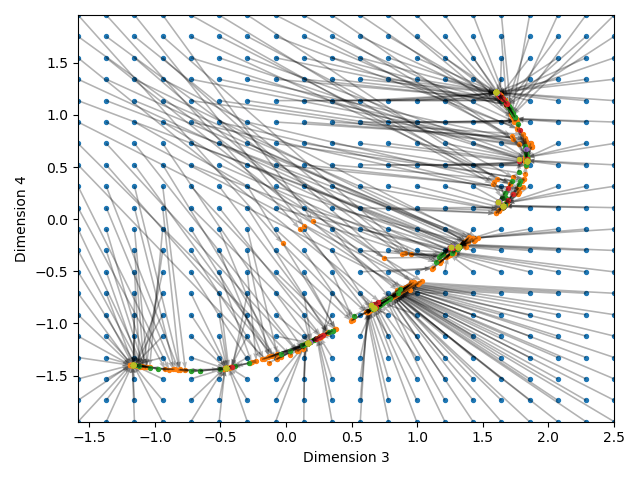

In [151]:
plt.figure()
start = None
for p2 in pts:
    end = p2.t()
    if start is not None:
        delta = end - start
        plt.quiver(*start, *delta, angles='xy', scale_units='xy', scale=1, lw=0.2, alpha=0.3)
    plt.scatter(*end, s=8)
    start = end
    pass

plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.xlim(pts[...,0].min(), pts[...,0].max())
plt.ylim(pts[...,1].min(), pts[...,1].max())
plt.tight_layout();
util.save_figure(f'proj_{len(pts)-1}_{ix}_{iy}', root=figure_dir);

In [152]:
bgdim

[0, 5]

In [153]:
berr = bts[1:].sub(bts[:-1]).abs().max(-1)[0]
ierr = ots[1:].sub(ots[:-1]).abs().max(-1)[0]
perr = pts[1:].sub(pts[:-1]).abs().max(-1)[0]
perr.shape, ierr.shape, berr.shape

(torch.Size([8, 400]), torch.Size([8, 400]), torch.Size([8, 400]))

In [154]:
# p = perr[1:].sub(perr[:-1]).max(-1)[0]
# b = berr[1:].sub(berr[:-1]).max(-1)[0]
# ie = ierr[1:].sub(ierr[:-1]).max(-1)[0]
# p = perr[1:].sub(perr[:-1])#.mean(-1)
# # b = berr[1:].sub(berr[:-1])#.mean(-1)

p = perr.mean(-1)
b = berr.mean(-1)
ie = ierr.mean(-1)
p = perr.max(-1)[0]
b = berr.max(-1)[0]
ie = ierr.max(-1)[0]

In [155]:
ie, p, b

(tensor([2.3782e-01, 1.9709e-01, 7.1046e-02, 4.6383e-02, 5.5419e-03, 8.7523e-04,
         1.1015e-04, 9.1791e-06]),
 tensor([2.9608e+00, 9.3429e-01, 2.5729e-01, 1.8168e-01, 1.0223e-01, 1.2360e-02,
         7.5674e-04, 4.1127e-05]),
 tensor([1.6034e+00, 1.7401e+00, 2.6088e-01, 2.7267e-01, 1.4863e-01, 1.6928e-02,
         1.0423e-03, 6.3300e-05]))

<IPython.core.display.Javascript object>


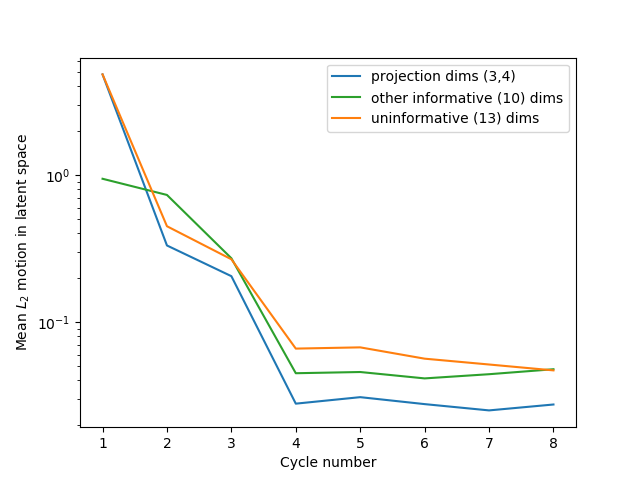

In [58]:
plt.figure()

num = np.arange(len(p))+1

plt.plot(num,p, c='C0', label=f'projection dims ({ix},{iy})');
plt.plot(num,ie, c='C2', label=f'other informative ({len(idim)}) dims');
plt.plot(num,b, c='C1', label=f'uninformative ({len(bgdim)}) dims');
plt.yscale('log');
plt.legend();
plt.xlabel('Cycle number')
plt.ylabel('Mean $L_2$ motion in latent space');
util.save_figure(f'latent_motion_{ix}_{iy}', root=figure_dir);

In [156]:
factor_types = ['per', 'per', 'per', 'seq', 'cat', 'seq']
factors

['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']

In [157]:
# ind = torch.tril_indices(N,N,-1)
# iq[:,ind].shape
# ind.shape

In [158]:
def per_dists(N):
    qq = torch.arange(N).unsqueeze(-1)/N
    qq = qq[torch.tril_indices(N,N,-1)]
    qa = torch.cat([qq.mul(2*np.pi).sin(), qq.mul(2*np.pi).cos()], -1)
    pD = qa[1].sub(qa[0]).pow(2).sum(-1).sqrt()
    return pD
def seq_dists(N):
    qq = torch.arange(N).unsqueeze(-1)/N
    qq = qq[torch.tril_indices(N,N,-1)]
    lD = qq[0].sub(qq[1]).pow(2).sum(-1).sqrt()
    return lD
def cat_dists(N):
    N = N*(N-1)//2
    return torch.ones(N).float()
dist_fns = {'cat':cat_dists, 'seq':seq_dists, 'per':per_dists}
d_order = ['cat','seq','per']

def dist_mat(N):
    return torch.stack([cat_dists(N), seq_dists(N), per_dists(N)], -1)


In [159]:
rq = []
for idx, (name, typ, invs) in enumerate(zip(factors, factor_types, interventions)):
    
    B,N,C,H,W = invs.shape
#     true = dist_fns[typ](N)
    true = dist_mat(N)
    true /= true.norm(dim=0,keepdim=True)
    
    with torch.no_grad():
        iq = model.encode(invs.view(B*N,C,H,W))
        if isinstance(iq, distrib.Normal):
            iq = iq.loc
        iq = iq.view(B,N,D).cpu()
    
    i,j = torch.tril_indices(N,N,-1)
    pred = iq[:,i].sub(iq[:,j]).pow(2).sum(-1)
    pred /= pred.norm(dim=-1, keepdim=True)
    
    rq.append(pred @ true)
    
#     break
rq = torch.stack(rq)
rq.shape

torch.Size([6, 20, 3])

<IPython.core.display.Javascript object>


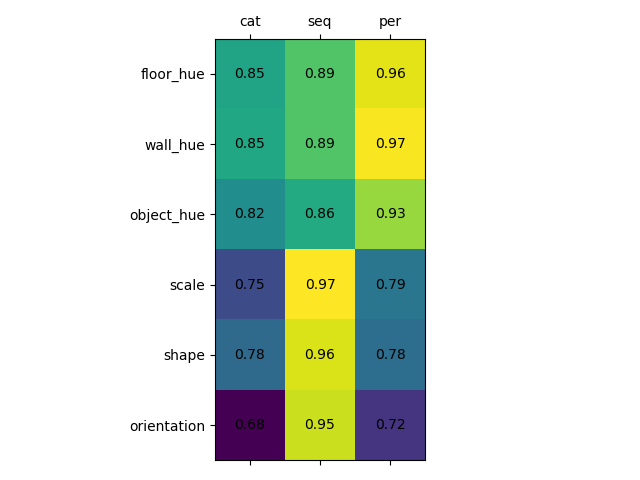

In [160]:
util.plot_mat(rq.mean(1), val_fmt=2);
plt.yticks(range(len(factors)), factors)
plt.xticks(range(len(d_order)), d_order);
plt.tight_layout()
util.save_figure(f'repr_quality', root=figure_dir);

In [171]:
from torch.autograd import grad

In [172]:
bidx = 1
q = Q[bidx].clone()
q = Q.clone()

In [173]:
def ae_cycle(q):
    im = model.decode(q.to(device))
    q = model.encode(im)
    return im.cpu(), q.cpu()

In [174]:
for param in model.parameters():
    param.requires_grad = False
q.requires_grad = True

In [175]:
# bq = q.unsqueeze(0).expand(12, -1)
# bq.shape

In [176]:
xh, qh = ae_cycle(q)
xh.shape, qh.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64, 12]))

In [177]:
gs = []
for i in range(12):
    obj = qh[:,i].sum(0)
    gr = grad(obj, q, retain_graph=True, only_inputs=True)[0]
    gs.append(gr)
gd = torch.stack(gs)
gd.shape

torch.Size([12, 64, 12])

In [178]:
obj = F.mse_loss(q.to(device),qh.to(device), reduction='none').sum(0)
gs = []
for o in obj:
    gr = grad(o, q, retain_graph=True, only_inputs=True)[0]
    gs.append(gr)
gl = torch.stack(gs)
gl.shape
# gl = grad(obj, q.to(device), retain_graph=True, only_inputs=True)[0]
# gl.shape

torch.Size([12, 64, 12])

In [179]:
g = gd.abs().mean(1)
# g = gd[:,np.random.randint(g.size(1))]

# g = gl.mean(1)

g = g.abs()

<IPython.core.display.Javascript object>


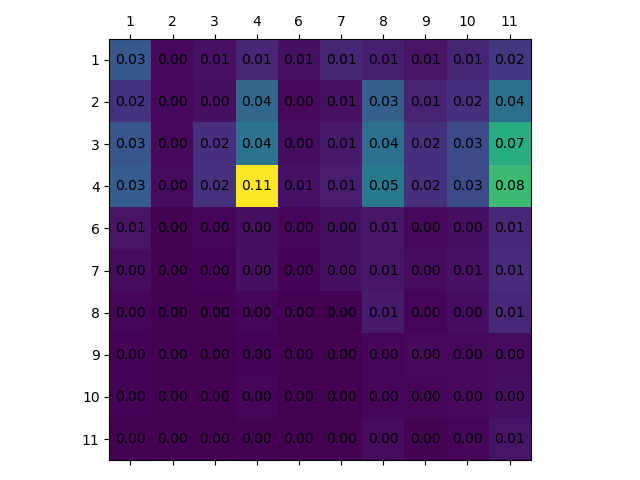

In [180]:
util.plot_mat(g[sel][:,sel], val_fmt=2);
# plt.ylabel('Intervention')
# plt.xlabel('Response')
plt.xticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.yticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.tight_layout()
util.save_figure(f'jacobian-sel', root=figure_dir)
# util.save_figure(f'{run_name}_sel_responses', root=figure_dir)

<IPython.core.display.Javascript object>


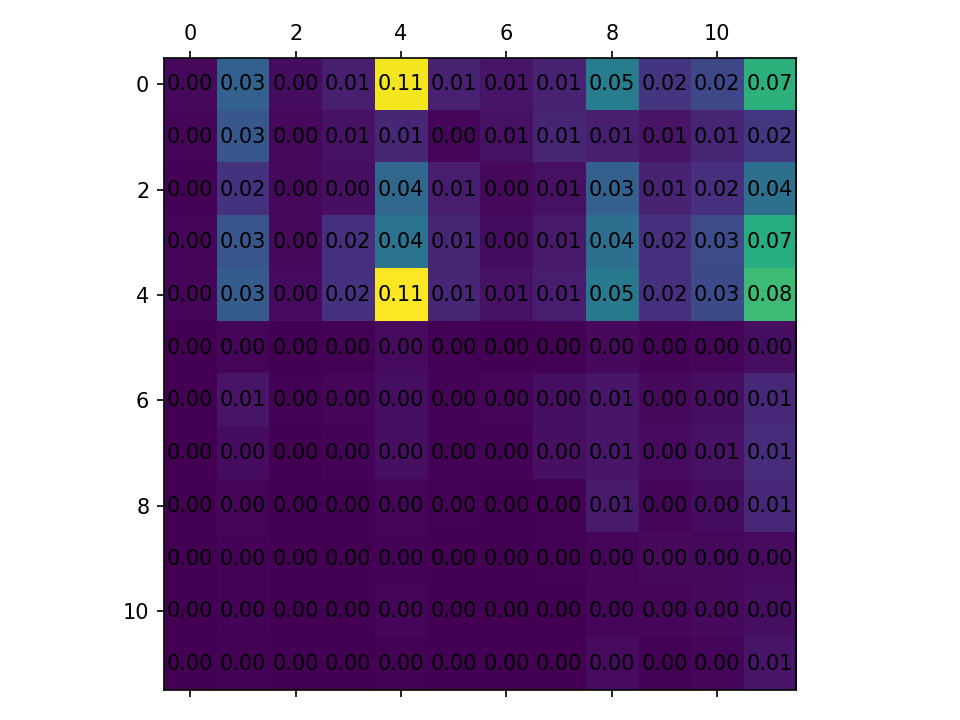

In [69]:
util.plot_mat(g, val_fmt=2);
plt.tight_layout();
util.save_figure(f'jacobians', root=figure_dir)

In [56]:
gd.shape

torch.Size([12, 64, 12])

In [57]:
# start = q[...,[ix,iy]].cpu().detach().t()
# delta = gd[[ix,iy]][...,[ix,iy]].diagonal(dim1=0,dim2=-1).cpu().detach().t().mul(1)

# plt.figure()
# plt.scatter(*start)
# # sel = slice(0,-1)
# plt.quiver(*start, *delta,angles='xy', scale_units='xy', scale=1, lw=0.5, alpha=0.5)
# # plt.scatter(*end)
# plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# plt.tight_layout()
# # util.save_figure(f'2D_traversal_projection_factor{factor_dim}_{ix}_{iy}', root=figure_dir);

In [181]:
steps = 20

stretch = 0.1
mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg
mn, mx = mn.view(-1), mx.view(-1)

In [182]:
bidx = 1
q = Q[bidx].clone()

In [183]:
ix, iy = 0, 4
# ix, iy = 6, 7
# ix, iy = 8, 11
# ix, iy = 9, 10
# ix, iy = 1, 9

In [184]:
cx, cy = torch.meshgrid(torch.linspace(mn[ix],mx[ix],steps), torch.linspace(mn[iy],mx[iy],steps))
cx = cx.reshape(-1)
cy = cy.reshape(-1)

vecs = q.expand(len(cx), q.size(0)).contiguous()
vecs[:, ix] = cx
vecs[:, iy] = cy
vecs.shape

torch.Size([400, 12])

In [185]:
def ae_cycle(q):
    im = model.decode(q.to(device))
    q = model.encode(im)
    return im.cpu(), q.cpu()

In [186]:
with torch.no_grad():
    oq = ae_cycle(vecs)[1]
    
q1, q2 = vecs.cpu().clone().div(scales.cpu().unsqueeze(0)), oq.cpu().clone().div(scales.cpu().unsqueeze(0))
q1.shape, q2.shape

(torch.Size([400, 12]), torch.Size([400, 12]))

In [187]:
dl = q2 - q1
dl.shape

torch.Size([400, 12])

In [188]:
mags = dl.abs()[...,[ix,iy]].sum(-1).view(steps,steps)
# mags = mags.clamp(max=1)
mags.shape

torch.Size([20, 20])

<IPython.core.display.Javascript object>


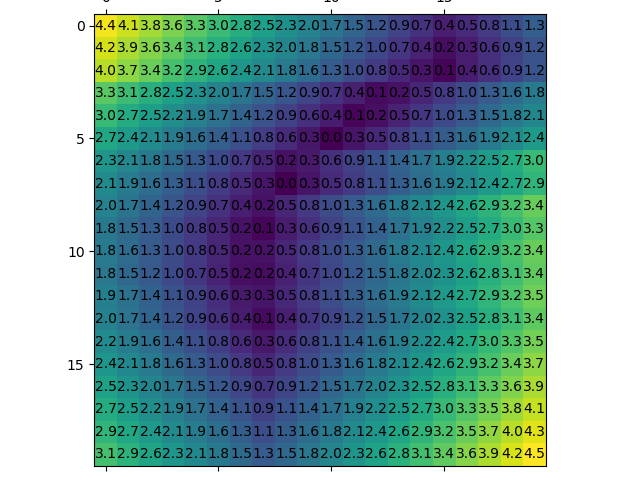

<IPython.core.display.Javascript object>


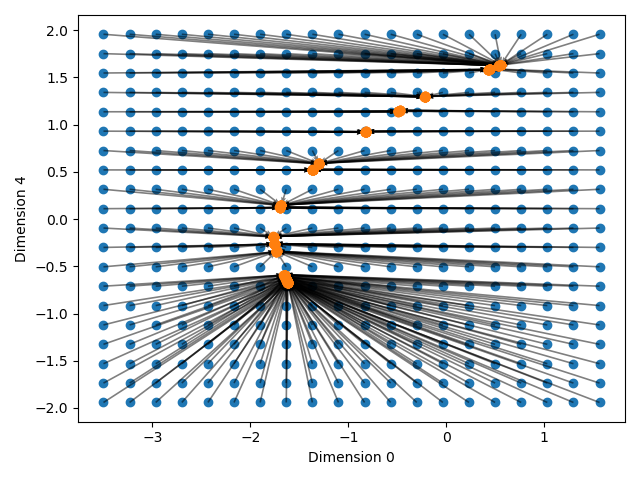

In [189]:
# plt.figure()
# plt.imshow(mags)
util.plot_mat(mags.t().numpy()[::-1], val_fmt=1);

start, end = q1.cpu().t()[[ix,iy]], q2.cpu().t()[[ix,iy]]

plt.figure()
plt.scatter(*start)
delta = end - start
# sel = slice(0,-1)
plt.quiver(*start, *delta,angles='xy', scale_units='xy', scale=1, lw=0.5, alpha=0.5)
plt.scatter(*end)
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')

plt.tight_layout();
# util.save_figure(f'2D_traversal_projection_factor{factor_dim}_{ix}_{iy}', root=figure_dir);